## 创建项目环境和基本依赖

In [ ]:
uv init deep-research-quickstart
cd deep-research-quickstart
mkdir src
uv add jinja2 firecrawl-py socksio
uv add langchain langchain-openai langchain_tavily
uv add langgraph langgraph-supervisor


## 一、模型

In [1]:
import os
from src.models.chat_model import chat_model_doubao

print(chat_model_doubao.invoke("你好，豆包").content)

你好呀！有什么问题我都可以帮你解答，尽管跟我说。 


In [2]:
import os
from src.models.chat_model import chat_model

print(chat_model.invoke("你好").content)

你好！有什么我可以帮助你的吗？


## 二、工具

In [ ]:
# 导入网页爬取工具
from src.tools.web_crawl import web_crawl
import os

# 检查 FIRECRAWL_API_KEY 环境变量
if not os.getenv("FIRECRAWL_API_KEY"):
    print("⚠️  警告: 未设置 FIRECRAWL_API_KEY 环境变量")
    print("请设置环境变量: export FIRECRAWL_API_KEY='your_api_key'")
else:
    print("✅ FIRECRAWL_API_KEY 已配置")

# 基本爬取示例
try:
    # 爬取一个示例网页
    url = "https://docs.byteplus.com/en/docs/byteplus-media-live/docs-changelog"
    print(f"\n正在爬取: {url}")
    
    content = web_crawl.invoke(url)
    
    print(f"\n爬取成功! 内容预览:")
    print("=" * 50)
    # 只显示前500个字符
    print(content[:500] + "...")
    
except Exception as e:
    print(f"爬取失败: {e}")
    print("请确保已设置正确的 FIRECRAWL_API_KEY")


使用chatmodel结合爬虫工具

In [ ]:
# 高级示例：爬取网页内容并用AI分析
from src.models.chat_model import chat_model
from langchain.schema import SystemMessage, HumanMessage

def analyze_webpage(url, question):
    """爬取网页并用AI分析内容"""
    try:
        print(f"正在爬取: {url}")
        
        # 爬取网页内容
        content = web_crawl.invoke(url)
        
        if not content:
            return "爬取失败或内容为空"
            
        print(f"爬取成功，内容长度: {len(content)} 字符")
        
        # 使用AI分析内容
        response = chat_model.invoke([
            SystemMessage(content="""你是一个视频云产品专家。请基于提供的网页内容，回答相关问题。
            要求：
            1. 仔细阅读网页内容
            2. 针对用户问题给出准确回答
            3. 如果内容不足以回答问题，请明确说明
            4. 用中文回答"""),
            HumanMessage(content=f"网页内容:\n{content[:3000]}\n\n用户问题: {question}")
        ])
        
        return response.content
        
    except Exception as e:
        return f"分析失败: {e}"

# 示例使用
if os.getenv("FIRECRAWL_API_KEY") and os.getenv("DOUBAO_API_KEY"):
    # 分析Python官网
    result = analyze_webpage(
        "https://docs.byteplus.com/en/docs/byteplus-media-live/docs-changelog", 
        "把过去发布的特征整理成mardown格式；"
    )
    print("\nAI分析结果:")
    print("=" * 50)
    print(result)
else:
    print("需要设置 FIRECRAWL_API_KEY 和 DOUBAO_API_KEY 环境变量才能运行此示例")


# 三、单智能体Agent

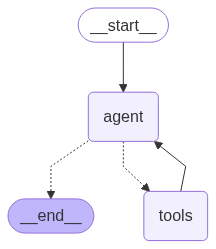

================================ Human Message =================================

2025年NBA总决赛结果怎么样？
================================== Ai Message ==================================
Name: researcher
Tool Calls:
  web_search (call_ePdSJ0y0D6NR1NYtpjfUZY4z)
 Call ID: call_ePdSJ0y0D6NR1NYtpjfUZY4z
  Args:
    query: 2025 NBA Finals results
================================= Tool Message =================================
Name: web_search

{'query': '2025 NBA Finals results', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'NBA Finals 2025 - Thunder-Pacers news, schedule, scores and highlights ...', 'url': 'https://www.espn.com/nba/story/_/id/44610574/nba-finals-2025-postseason-news-scores-highlights', 'content': 'NBA Finals 2025 - Thunder-Pacers news, schedule, scores and highlights - ESPN NBA *   NBA Final    OKC wins series 4-3    * Image 1 Indiana Pacers Pacers IND 91 * Image 2 Oklahoma City Thunder Thunder OKC 103 NBA Finals - Game 7 OKC wins series 4-3 N

In [ ]:
import uuid
import os
from typing import Optional
from langgraph.graph.graph import CompiledGraph
from src.agents.researcher import researcher


def run_agent(agent: CompiledGraph, message: str):
    result = agent.stream(
        {"messages": [{"role": "user", "content": message}]},
        stream_mode="values",
        config={"thread_id": uuid.uuid4()},
    )
    for chunk in result:
        messages = chunk["messages"]
        last_message = messages[-1]
        last_message.pretty_print()



from IPython.display import Image, display

png_data = researcher.get_graph()

png_data = researcher.get_graph().draw_mermaid_png() 
display(Image(png_data))


run_agent(researcher, "2025年NBA总决赛谁赢了？")